# Grad-CAM Visualization

## 1. Initialization

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os

os.chdir("..")
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
from torchvision import transforms
from PIL import Image
import cv2
import warnings

warnings.filterwarnings("ignore")

## 2. Model

In [3]:
MODEL = "results/models/eff_net_400x400.pt"

# Define Backbone
weights = EfficientNet_B3_Weights.DEFAULT
model = efficientnet_b3(weights=weights)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1536, out_features=5, bias=True),
)
model.load_state_dict(torch.load(MODEL))

model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

## 3. Grad-CAM implementation

In [4]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.feature_maps = None
        self.hook()

    def hook(self):
        def forward_hook(module, input, output):
            self.feature_maps = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_image, target_class):
        self.model.eval()
        output = self.model(input_image)
        one_hot_output = torch.zeros((1, output.size()[-1]), dtype=torch.float32)
        one_hot_output[0][target_class] = 1

        self.model.zero_grad()
        output.backward(gradient=one_hot_output, retain_graph=True)

        guided_gradients = self.gradients.data.numpy()[0]
        target = self.feature_maps.data.numpy()[0]

        weights = np.mean(guided_gradients, axis=(1, 2))
        cam = np.zeros(target.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (400, 400))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

In [5]:
# Preprocess image
def preprocess_image(img_path):
    preprocess = transforms.Compose(
        [
            transforms.Resize((400, 400)),
            transforms.ToTensor(),
            # transforms.Normalize(mean = [0.4433, 0.3067, 0.2192], std = [0.2747, 0.2011, 0.1682]),
        ]
    )
    img = Image.open(img_path).convert("RGB")
    img = preprocess(img).unsqueeze(0)
    return img

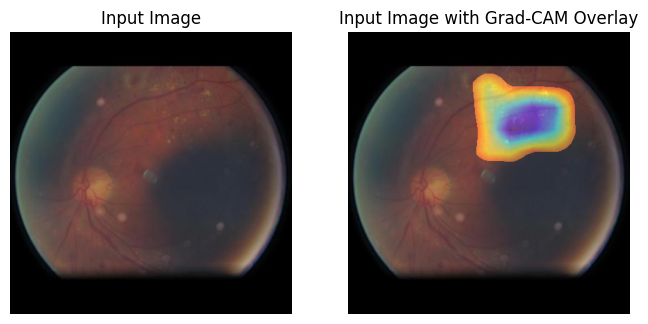

In [47]:
# CAM overlay function
def overlay_cam_on_image(
    img_path,
    cam,
    threshold=0.3,
    blur_value=11,
    morph_op=None,
    morph_kernel_size=(3, 3),
):
    img = cv2.imread(img_path, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (400, 400))

    # Normalize
    cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))
    cam = np.uint8(255 * cam)

    # Create a binary mask with the threshold
    mask = cam > np.uint8(255 * threshold)

    # Morphological operations to improve edge appearance
    if morph_op:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, morph_kernel_size)
        if morph_op == "dilate":
            mask = cv2.dilate(mask, kernel, iterations=1)
        elif morph_op == "erode":
            mask = cv2.erode(mask, kernel, iterations=1)

    # Gaussian blur to the binary mask for smooth edges
    mask = cv2.GaussianBlur(mask.astype(np.float32), (blur_value, blur_value), 0)

    heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    heatmap = np.where(mask[..., None] > 0, heatmap, 0).astype(np.uint8)

    # Blend the original image with the masked heatmap
    cam_image = cv2.addWeighted(img, 1, heatmap, 0.5, 0)

    return cam_image


input_image_path = "data/images_keep_ar/36190_right.jpeg"
input_image = preprocess_image(input_image_path)
target_class = 3

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(np.transpose(input_image.squeeze(0).numpy(), (1, 2, 0)))
plt.axis("off")

grad_cam = GradCAM(model, model.features[8])
cam = grad_cam.generate_cam(input_image, target_class)
cam_image = overlay_cam_on_image(input_image_path, cam)

# Image with CAM overlay
plt.subplot(1, 2, 2)
plt.title("Input Image with Grad-CAM Overlay")
plt.imshow(cam_image)
plt.axis("off")

plt.show()